In [1]:
import os
from pathlib import Path
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from lib.city_blocks import load_street_graph, remove_deadends, city_blocks
from lib.config import tmp_folder_path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

%matplotlib inline

In [2]:
def fix_polygon(pol, fixed_pgs):
    if isinstance(pol, MultiPolygon):
        #print('Multipolygon instance')
        for p in pol.geoms:
            clean = p.buffer(0.0)
            if clean.geom_type == 'Polygon':
                if clean.is_valid:
                    p = clean
                    fixed_pgs.append(p)
            elif clean.geom_type == 'MultiPolygon':
                fix_polygon(clean, fixed_pgs)
    else:
        clean = pol.buffer(0.0)
        if clean.geom_type == 'Polygon':
            if clean.is_valid:
                pol = clean
                fixed_pgs.append(pol)
        elif clean.geom_type == 'MultiPolygon':
            fix_polygon(clean, fixed_pgs)

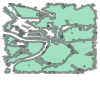

In [3]:
city_gdf = gpd.read_file('geojson/antwerp_grid_blocks.geojson').to_crs({'init': 'epsg:4326'})
city_polygon = city_gdf.geometry.unary_union
city_polygon

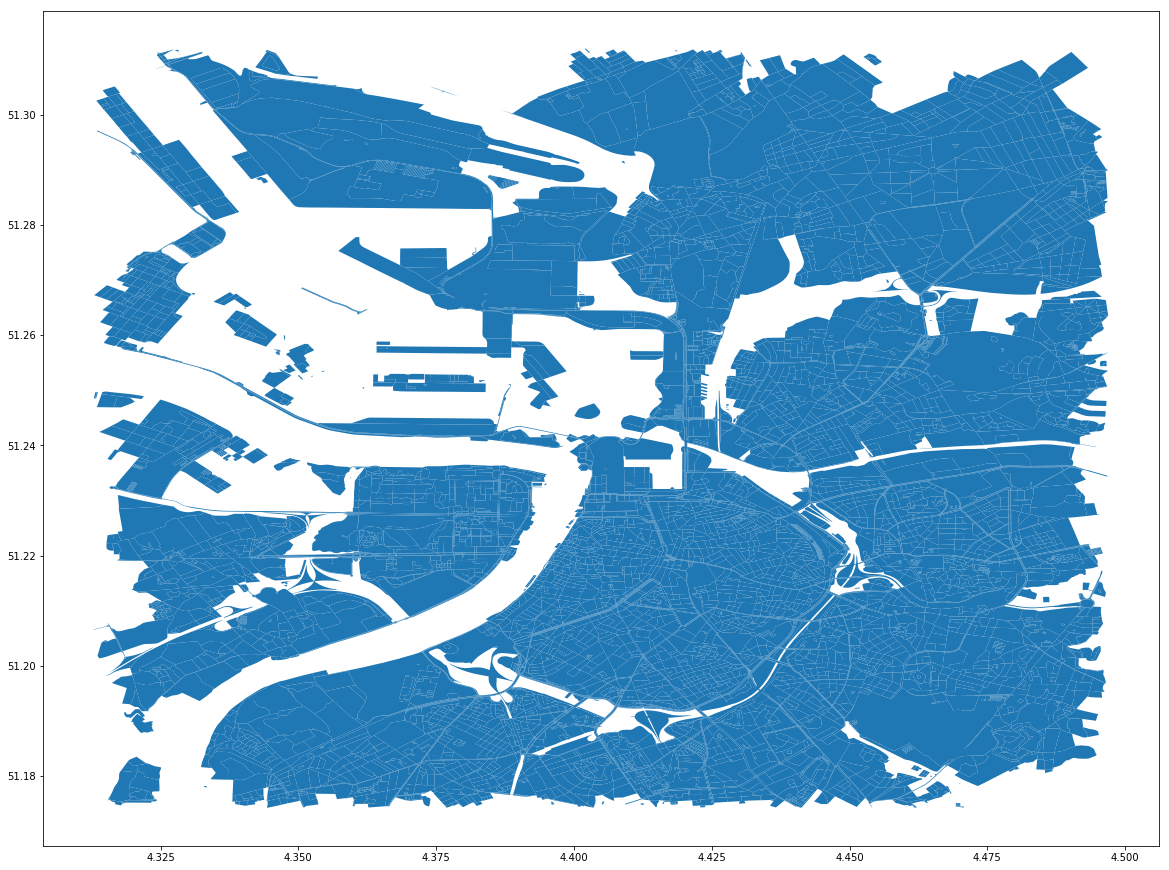

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
city_gdf.plot(ax=ax)

In [5]:
city_gdf.head()

id                                           geometry
0  0  POLYGON ((4.4202885 51.2071573, 4.420148 51.20...
1  1  POLYGON ((4.4447741 51.2298219, 4.4448962 51.2...
2  2  POLYGON ((4.4040164 51.2174279, 4.4039783 51.2...
3  3  POLYGON ((4.4609466 51.2716366, 4.4605986 51.2...
4  4  POLYGON ((4.4637082 51.2727665, 4.4640513 51.2...

In [6]:
def get_overlaps(gdf):
    data_overlaps=gpd.GeoDataFrame(crs=gdf.crs)
    for index, row in tqdm(gdf.iterrows()):
        data_temp1=gdf.loc[gdf.id!=row.id,]
        # check if intersection occured
        overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
        if len(overlaps)>0:
            temp_list=[]
            # compare the area with threshold
            for i in overlaps:
                temp_area=gpd.overlay(gdf.loc[gdf.id==i,],gdf.loc[gdf.id==row.id,],how='intersection')
                #temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
                #if temp_area.shape[0]>0:
                data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=gdf.crs)
    return data_overlaps
    # get unique of list id
    #data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
    #data_overlaps=data_overlaps.drop_duplicates('sorted')
    #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

def remove_overlaps(gdf):
    gdf_copy = gdf.copy()
    for index, row in tqdm(gdf.iterrows()):
        data_temp1=gdf.loc[gdf.id!=row.id,]
        # check if intersection occured
        overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
        if len(overlaps)>0:
            for i in overlaps:
                new_polygon=gpd.overlay(gdf.loc[gdf.id==i,],gdf.loc[gdf.id==row.id,],how='difference')
                gdf_copy = gdf_copy[gdf_copy.id!=i]
                gdf_copy.append(new_polygon, ignore_index=True)                
    return gdf_copy
    # get unique of list id
    #data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
    #data_overlaps=data_overlaps.drop_duplicates('sorted')
    #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

In [7]:
city_gdf_no_overlaps = remove_overlaps(city_gdf)

11273it [13:12, 14.23it/s]


In [8]:
city_gdf_no_overlaps.shape

(11085, 2)

In [9]:
bbox_gdf = gpd.read_file('geojson/grid.json').to_crs({'init': 'epsg:4326'})
bbox_polygon = bbox_gdf.geometry.unary_union

#gdf = ox.gdf_from_place(place_name)
#buildings = ox.create_footprints_gdf(bbox_polygon, retain_invalid=True)
landuse = ox.create_footprints_gdf(bbox_polygon, footprint_type='landuse')
street_graph = ox.graph_from_polygon(bbox_polygon, simplify=False)
nodes, edges = ox.graph_to_gdfs(street_graph)

In [15]:
city_bck_st_gdf = city_gdf_no_overlaps[['geometry']].append(edges[['geometry']], ignore_index=True)
city_bck_st_gdf = city_bck_st_gdf.reset_index()
city_bck_st_gdf = city_bck_st_gdf.rename(index=str, columns={"index": "id"})

In [17]:
city_bck_st_gdf.describe()

id
count  171781.000000
mean    85890.000000
std     49589.047633
min         0.000000
25%     42945.000000
50%     85890.000000
75%    128835.000000
max    171780.000000

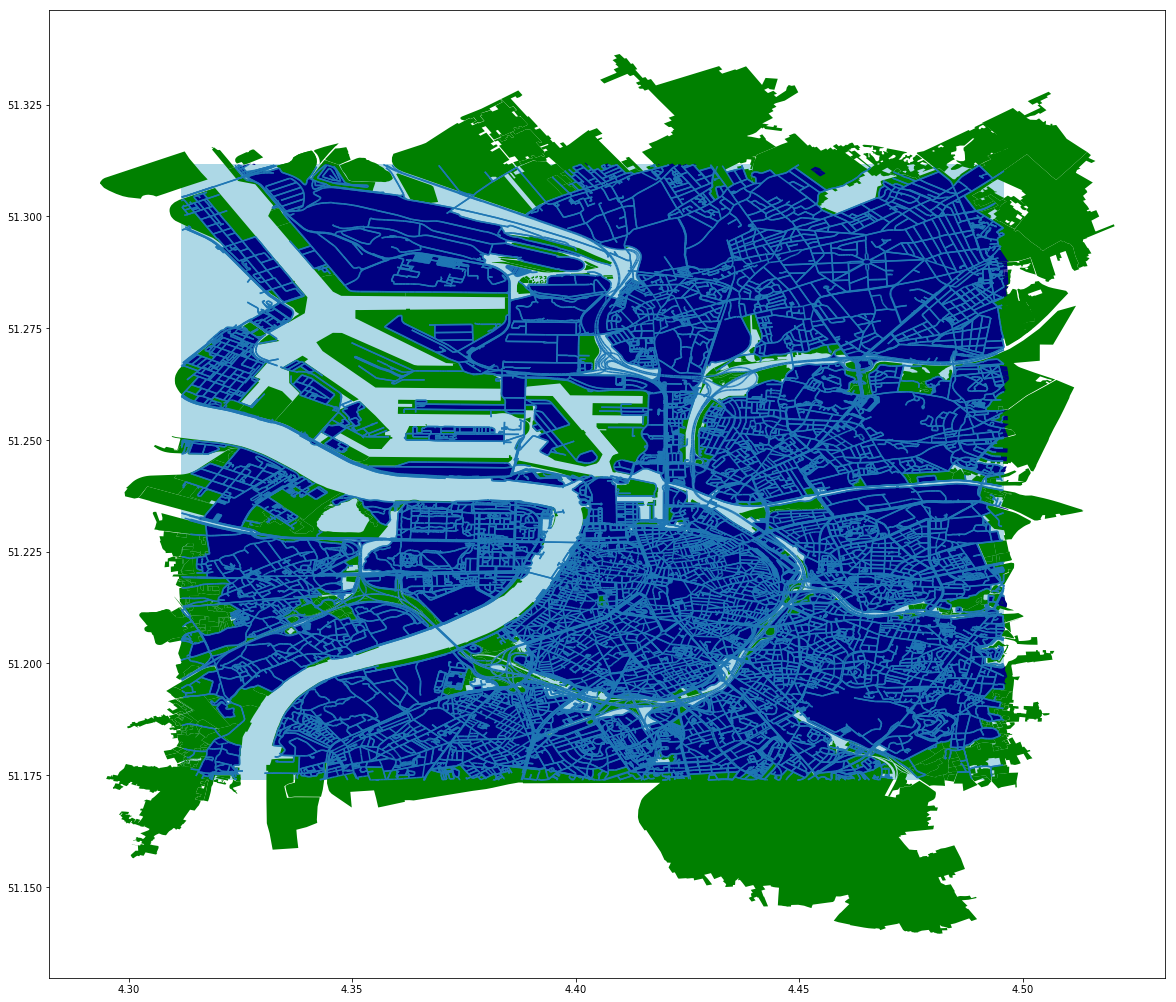

In [18]:
fig0, ax0 = plt.subplots(figsize=(20,20))
bbox_gdf.plot(ax=ax0, facecolor='#add8e6')
#edges.plot(ax=ax0, linewidth=1, edgecolor='#BC8F8F')
#area.plot(ax=ax0, facecolor='#000080')
landuse.plot(ax=ax0, facecolor='#008000')
city_bck_st_gdf.plot(ax=ax0, facecolor='#000080')

In [22]:
diff_city_gdf = gpd.overlay(landuse.to_crs({'init': 'epsg:4326'}), city_gdf_no_overlaps.to_crs({'init': 'epsg:4326'}), how='difference')
bbox_city_gdf = gpd.overlay(diff_city_gdf, bbox_gdf, how='intersection')

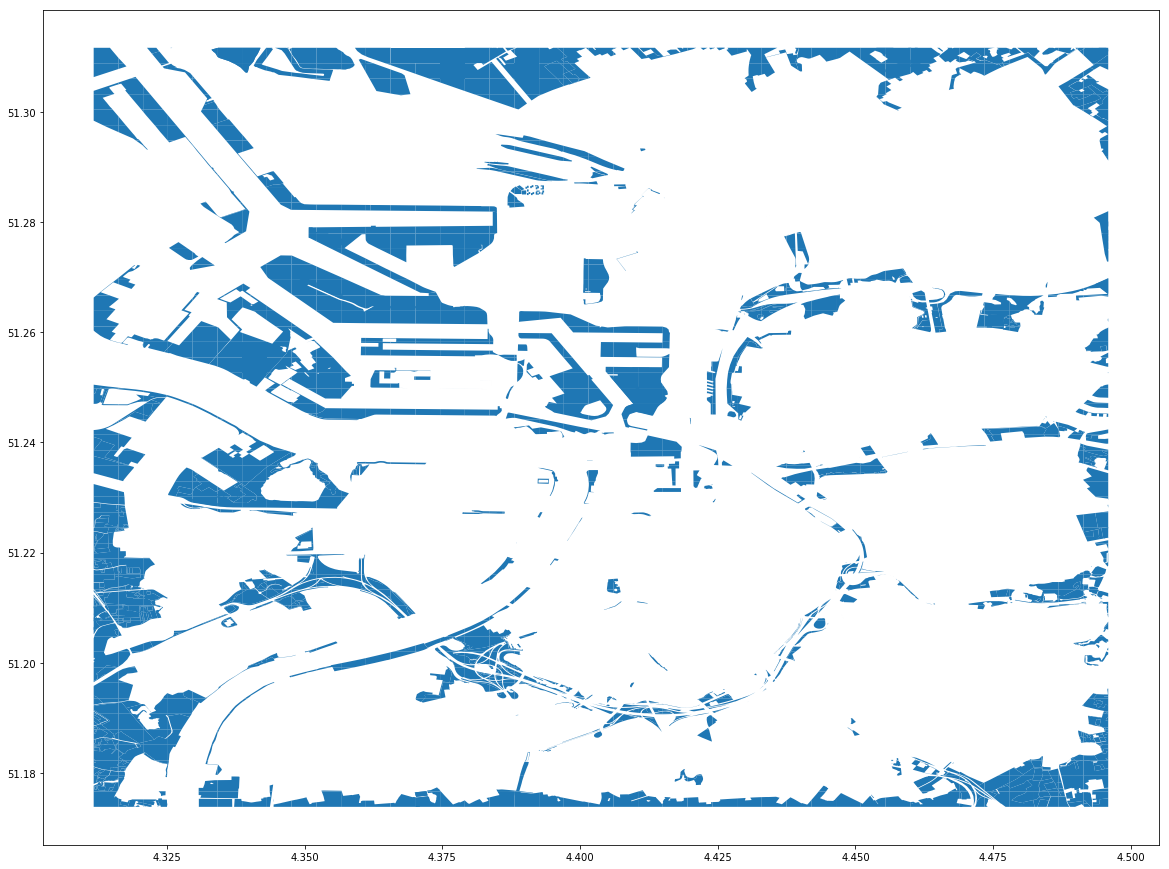

In [23]:
fig2, ax2 = plt.subplots(figsize=(20,20))
bbox_city_gdf.plot(ax=ax2)

In [24]:
new_city_gdf = gpd.overlay(bbox_city_gdf, city_gdf_no_overlaps.to_crs({'init': 'epsg:4326'}), how='union')

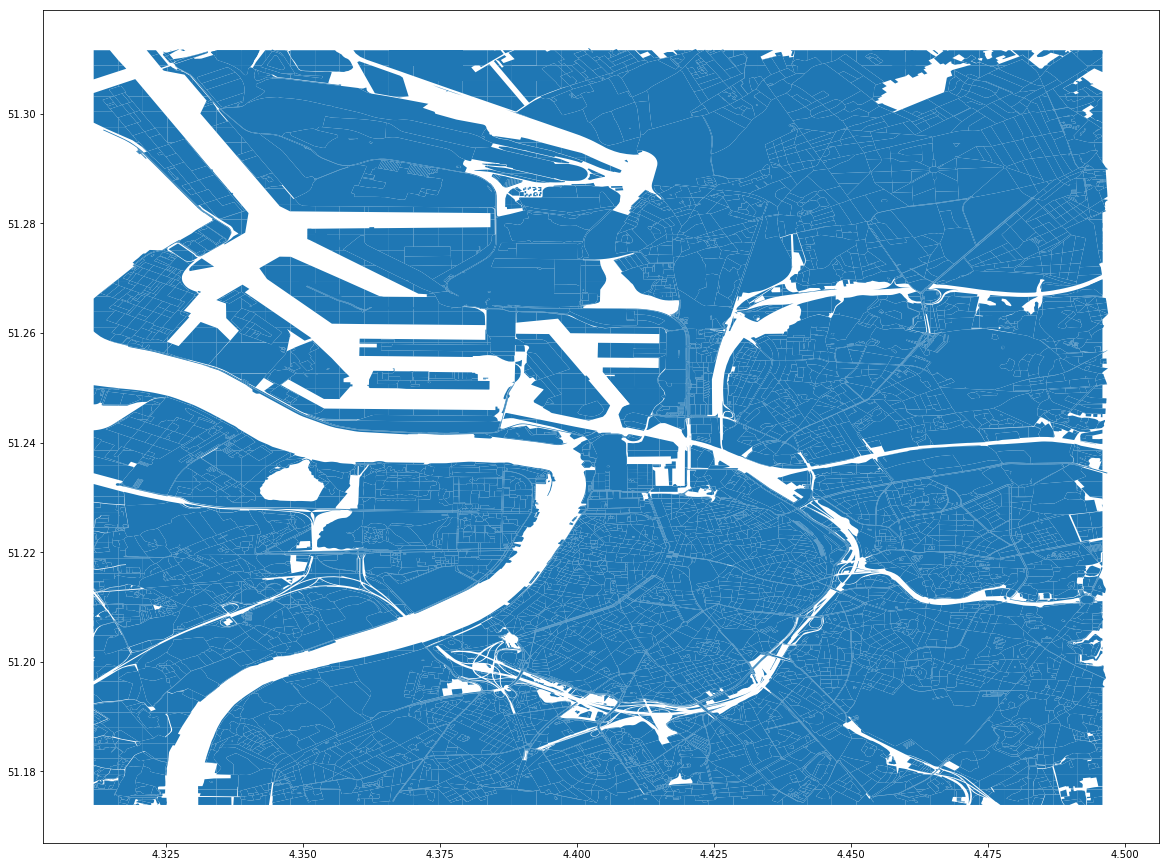

In [25]:
fig3, ax3 = plt.subplots(figsize=(20,20))
new_city_gdf.plot(ax=ax3)

In [26]:
assert new_city_gdf[new_city_gdf.is_valid == False].shape[0] == 0

In [34]:
blocks_gdf = new_city_gdf[['geometry']]
blocks_gdf = blocks_gdf.reset_index()
blocks_gdf = blocks_gdf.rename(index=str, columns={"index": "id"})

id                                           geometry
0   0  POLYGON ((4.492943282316815 51.30882230180237,...
1   1  POLYGON ((4.493240098064236 51.30853928400498,...
2   2  (POLYGON ((4.492586566597612 51.30807670662107...
3   3  POLYGON ((4.492586566597611 51.30807670662107,...
4   4  POLYGON ((4.491414815054791 51.2689159276494, ...

In [40]:
streets_gdf = edges[['geometry']]
streets_gdf = streets_gdf.reset_index()
streets_gdf = streets_gdf.rename(index=str, columns={"index": "id"})

In [41]:
blocks_streets_gdf.shape

(175345, 2)

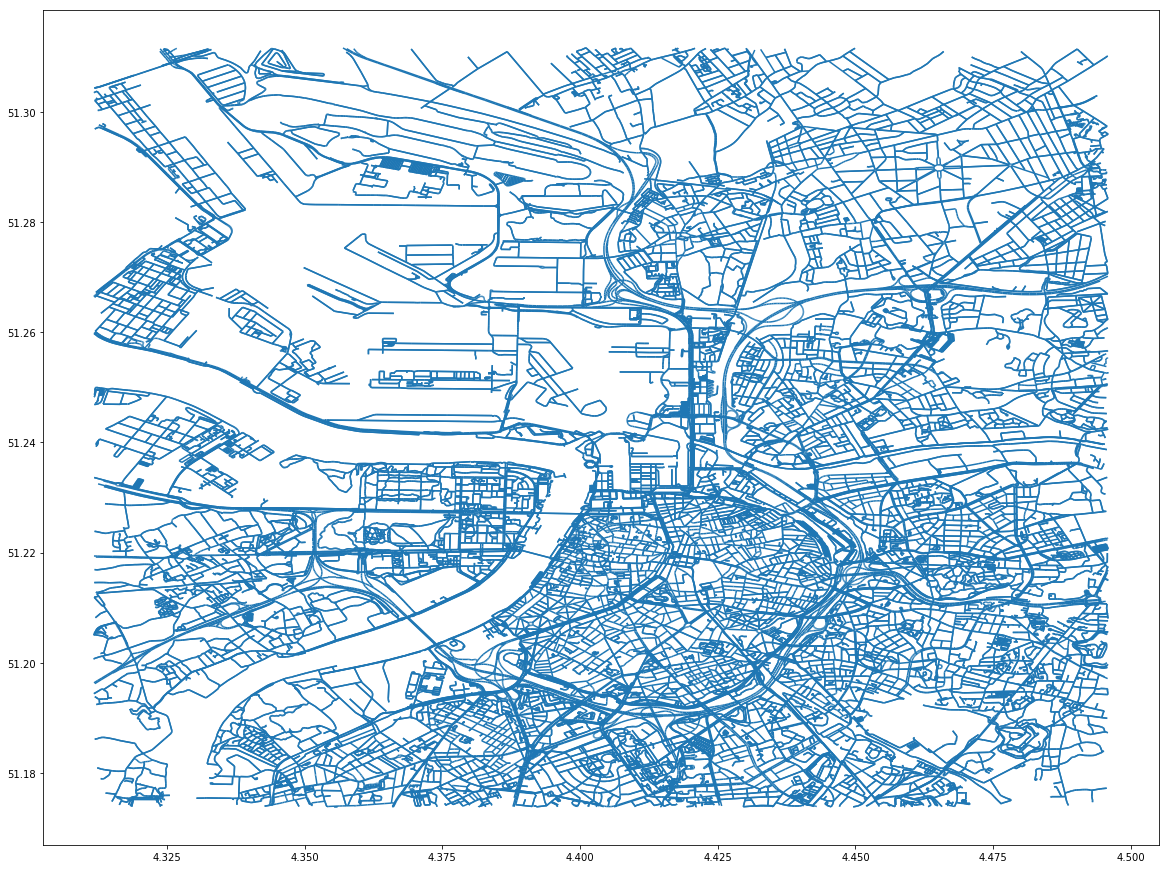

In [42]:
fig1, ax1 = plt.subplots(figsize=(20,20))
streets_gdf.plot(ax=ax1)

## Save areas as GeoJson

In [43]:
filename = 'antwerp_sq_grid_blocks'
geofile = Path(tmp_folder_path, filename).with_suffix('.geojson')

with open(geofile, 'w+') as af: 
    af.write(blocks_gdf.to_json())